# Ensemble Learning mit dem Titanic-Datensatz

- Der originale Datensatz kann hier abgerufen werden: https://www.kaggle.com/c/titanic
- Der hier verwendete Datensatz wurde zwecks Einfachheit bereits überarbeitet und angereichtert

## Lade Libraries und Daten

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

DF = pd.read_csv('data/titanic_enh.csv')

In [2]:
DF

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,0,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,1,2,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,0,1,1,4
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,1,2,0,3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,1,0,0,211536,1,NaN,0,0,1,1,5
887,888,1,1,"Graham, Miss. Margaret Edith",0,1,0,0,112053,2,B42,0,1,1,1,4
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,1,1,2,W./C. 6607,2,NaN,0,0,4,0,4
889,890,1,1,"Behr, Mr. Karl Howell",1,1,0,0,111369,2,C148,1,1,1,1,1


### Lade nötige Library/Libraries

In diesem Fall verwenden wir Decision Trees als Ausgangslage für das Ensemble Learning

In [3]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

### Trainiere drei weak learners parallel auf einem zufälligen Subset der Trainingsdaten (Bagging)

In [4]:
# Sample for KFold
df = DF.copy()
train, test = train_test_split(df, test_size=0.2)

# Create Input- and Output-Structure and train Decision Tree Classifer
training_columns = ['Pclass', 'Sex', 'Age','Fare','Embarked', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title']

# Train three Decision Trees on subset of training data
learners = []

for i in range(3):
    clf = DecisionTreeClassifier(max_depth = 3, criterion='entropy')
    
    sub_train, sub_test = train_test_split(train, test_size=0.8)
    
    X = sub_train[training_columns]
    y = sub_train[['Survived']]
    
    clf = clf.fit(X, y)
    learners.append(clf)

### Treffe Vorhersagen mit den Weak Learners basierend auf einer Mehrheitswahl (Majority Vote)

In [5]:
# Create Predictions based on the predictions of the three weak learners
X = test[training_columns]
y = test[['Survived']]

for i in range(3):
    y['Prediction_{}'.format(i)] = learners[i].predict(X)


y['Prediction_Final'] = y.iloc[:, -3:].sum(axis=1)
y['Prediction_Final'] = y['Prediction_Final'].apply(lambda x: 1 if x >= 3/2 else 0)

# Calculate Performance Metric
y['match'] = y['Survived'] == y['Prediction_Final']
performance =  sum(y['match']) / len(y)
print('Performance: {:.1%}'.format(performance))

Performance: 80.4%


### Suche Hyperparameter

Es können mehrere Parameter gesucht werden (Anzahl Weak learners, Grösse der Trainingsdaten, Maximale Tiefe des Baums, Voting-Regel, ...) in diesem Fall suchen wir die optimale Grösse der Trainingsdaten mit drei weak learners.

Die höchste Performance von 82.5% wurde mit einem Anteil von 90.0 Prozent am Trainingsset erreicht.


<AxesSubplot:>

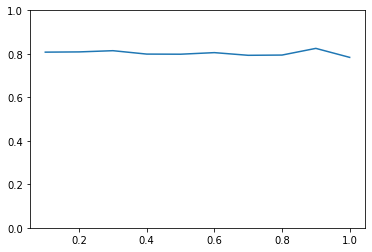

In [6]:
share_of_training_data = []
test_performance = []
number_of_learners = 3
tries = 10
max_performance = 0
max_performance_share = 0

for i in range(1, 11):
    share = i/10
    overall_perf = 0
    for j in range(tries):

        # Sample for KFold
        df = DF.copy()
        train, test = train_test_split(df, test_size=0.2)
        # Create Input- and Output-Structure and train Decision Tree Classifer
        training_columns = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title']
       
        # Train three Decision Trees on subset of training data
        learners = []
        
        for i in range(number_of_learners):
            clf = DecisionTreeClassifier(max_depth = 3, criterion='entropy')
            sub_train, sub_test = train_test_split(train, test_size=0.8)
            X = sub_train[training_columns]
            y = sub_train[['Survived']]
    
            clf = clf.fit(X, y)
            learners.append(clf)
            
        # Create Predictions based on the predictions of the three weak learners
        X = test[training_columns]
        y = test[['Survived']]

        for i in range(number_of_learners):
            y['Prediction_{}'.format(i)] = learners[i].predict(X)


        y['Prediction_Final'] = y.iloc[:, -3:].sum(axis=1)
        y['Prediction_Final'] = y['Prediction_Final'].apply(lambda x: 1 if x >= number_of_learners/2 else 0)

        # Calculate Performance Metric
        y['match'] = y['Survived'] == y['Prediction_Final']
        performance =  sum(y['match']) / len(y)
        overall_perf += performance
            
        
        
    share_of_training_data.append(share)
    test_performance.append(overall_perf/tries)
    if overall_perf/tries > max_performance:
        max_performance = overall_perf/tries
        max_performance_share = share

print('Die höchste Performance von {:.1%} wurde mit einem Anteil von {} Prozent am Trainingsset erreicht.'.format(max_performance, max_performance_share*100))
g = sns.lineplot(x=share_of_training_data, y=test_performance)
g.axes.set_ylim(0,1)
g